In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from model_explore.pytorch import io, trainer, utils, data
from monai.metrics import ConfusionMatrixMetric
from monai.networks.nets import UNet
import matplotlib.pyplot as plt
import torch, mlflow

In [10]:
model_save_path = '/mnt/simulations/ml_challenge/resunet_results_v2'
copick_config_path = "/mnt/simulations/ml_challenge/ml_config.json"
segmentation_name = 'segmentation'
my_channels = [32,64,128,128]
my_strides = [2,2,1]
my_num_res_units = 2

In [11]:
# Split Experiment into Train and Validation Runs
Nclass = io.get_num_classes(copick_config_path)
data_generator = data.train_generator(copick_config_path, 
                                      segmentation_name, 
                                      Nclasses = Nclass,
                                      tomo_batch_size = 20)
myRunIDs = data_generator.get_data_splits()

Number of training samples: 19
Number of validation samples: 3
Number of test samples: 2


In [4]:
voxel_size = 10
algorithm = 'wbp'
seg_name = 'segmentation'

root = io.load_copick_config(copick_config_path)
train_files = io.load_training_data(root, myRunIDs['train'], voxel_size, algorithm, seg_name)
val_files   = io.load_training_data(root, myRunIDs['validate'], voxel_size, algorithm, seg_name) 

100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


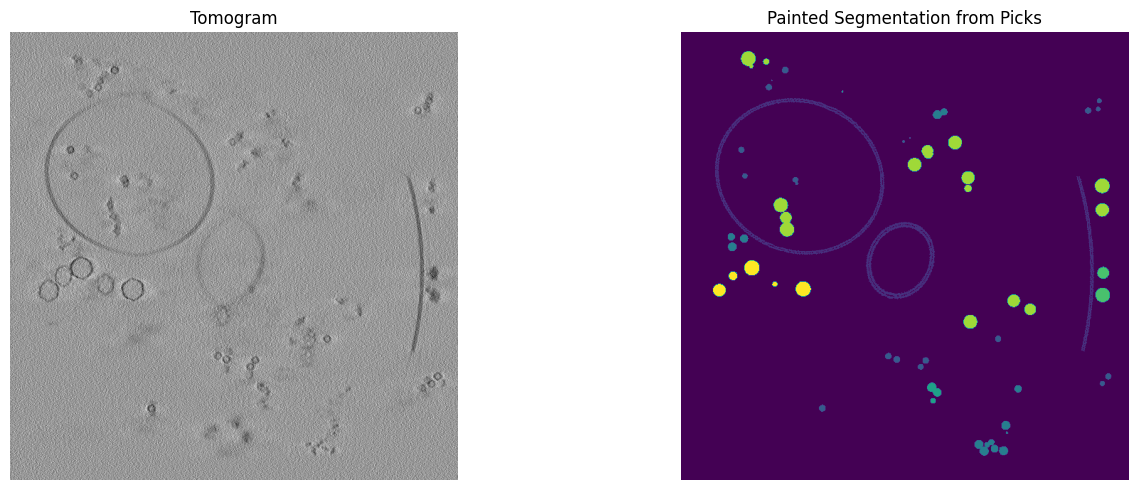

In [6]:
tomo_index = 0
vol_slice = 120

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(train_files[tomo_index]['image'][vol_slice],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(train_files[tomo_index]['label'][vol_slice], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Monai Functions
alpha = 0.4; beta = 0.6
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  
metrics_function = ConfusionMatrixMetric(include_background=False, metric_name=["recall",'precision','f1 score'], reduction="none")

# Create UNet Model and Load Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=Nclass,
    channels=my_channels,
    strides=my_strides,
    num_res_units=my_num_res_units,
).to(device)

# Optimizer
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)

# Create UNet-Trainer
train = trainer.unet(model, device, loss_function, metrics_function, optimizer)

#### Option 1: Store Parameters and Results with MLFlow

In [ ]:
# Set up ML-Flow
utils.mlflow_setup()

# Log ML-Flow Refrence and Start Training
mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local:5000")
mlflow.set_experiment('fake-search')

# Log training parameters.
params = {
    'learning_rate': lr, 
    'loss_function': loss_function.__class__.__name__,
    'metric_funciton': metrics_function.__class__.__name__,
    'optimizer': 'Adam',
    'train_run_ids': myRunIDs['train'],
    'validate_run_ids': myRunIDs['validate'],
    'test_run_ids': myRunIDs['test']
}
mlflow.log_params(params)

with mlflow.start_run():    
    train.mlflow_train(data_generator, model_save_path, verbose = True)
mlflow.end_run()


#### Option 2: Access Data and Results Locally

In [7]:
help(train.local_train)

Help on method local_train in module model_explore.pytorch.trainer:

local_train(data_load_gen, model_save_path='results', my_num_samples: int = 15, max_epochs: int = 100, val_interval: int = 15, reload_frequency: int = 15, verbose: bool = False) method of model_explore.pytorch.trainer.unet instance
    # Instead of Logging with ML-Flow, I want to return a dictionary with all the metrics



Training Progress:  19%|█▊        | 14/75 [02:45<10:04,  9.91s/epoch]

Epoch 15/75, avg_train_loss: 0.6480


Training Progress:  19%|█▊        | 14/75 [02:47<10:04,  9.91s/epoch]

Epoch 15/75, avg_recall: 0.5408
Epoch 15/75, avg_precision: 0.6147
Epoch 15/75, avg_f1_score: 0.5647


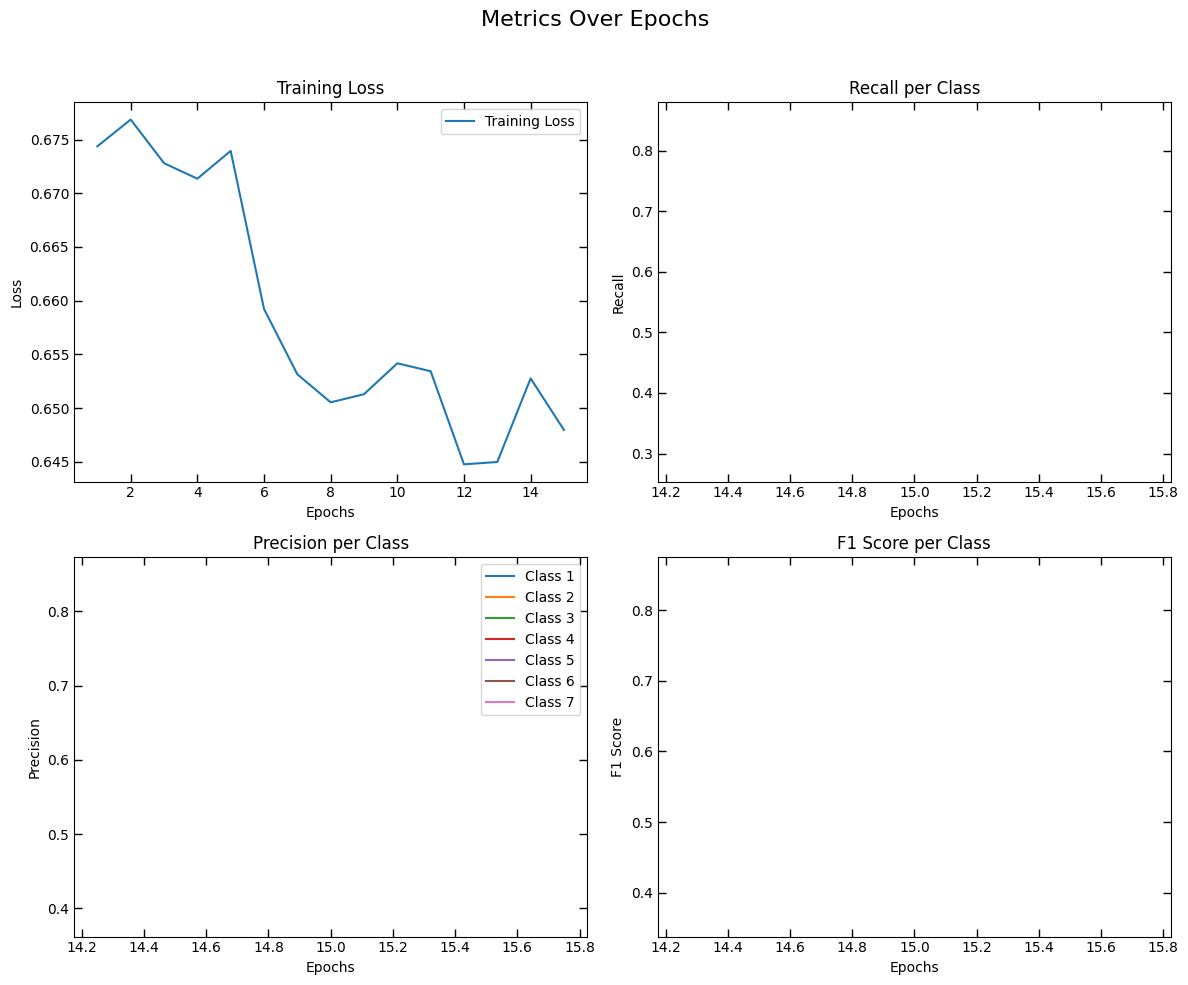

Training Progress:  20%|██        | 15/75 [02:57<11:51, 11.86s/epoch]


KeyboardInterrupt: 

In [ ]:
results = train.local_train(data_generator, 
                            model_save_path, 
                            verbose=True,
                            max_epochs = 75,
                            my_num_samples = 16,
                            reload_frequency = 5,
                            val_interval = 15)

protein_names = ['membrane', 'apoferritin', 'beta-amylase', 'beta-galactisade', 'ribosome', 'thyroglobulin', 'vlp']
train.plot_results(results, class_names = protein_names)

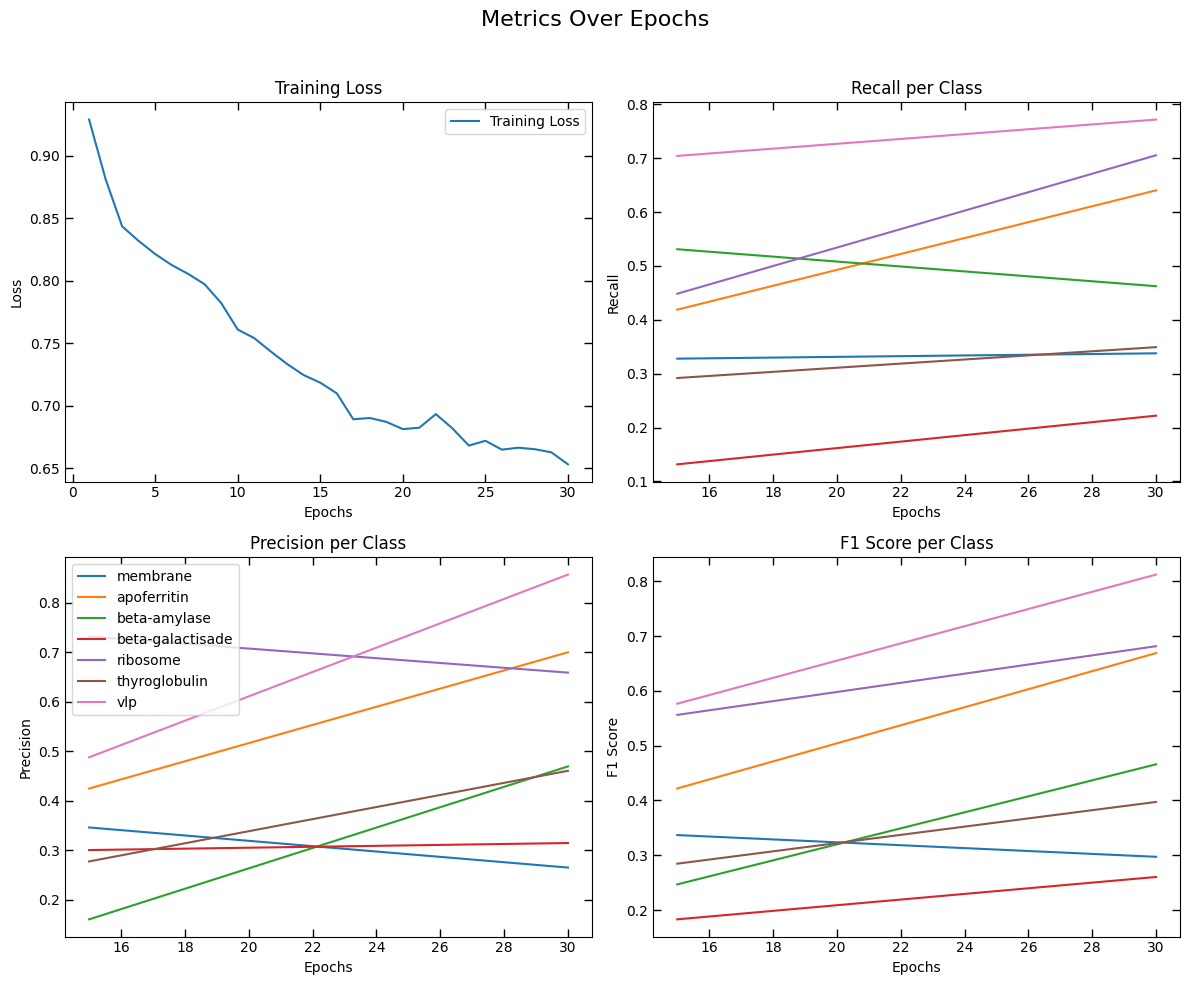

In [46]:
protein_names = ['membrane', 'apoferritin', 'beta-amylase', 'beta-galactisade', 'ribosome', 'thyroglobulin', 'vlp']
train.plot_results(results, class_names = protein_names)

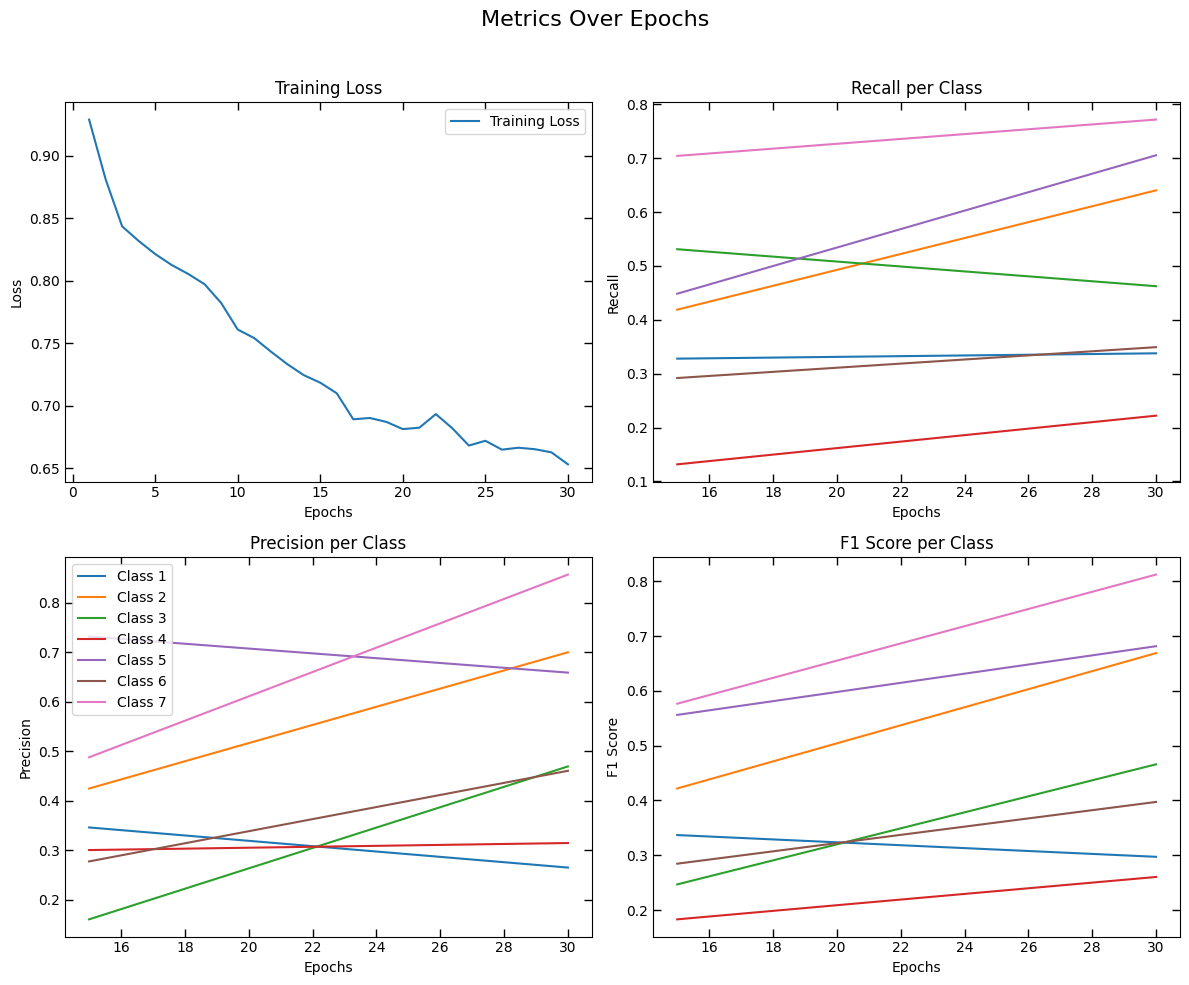

In [45]:
train.plot_results(results)